# Univariate Analysis - LC-MS

In this notebook we will perform a *univariate* analysis of LC-MS dataset from the the *Dementia research cohort*, as an alternative to the mulivariate PLS-DA analysis. For details of the study see the Metabolights Study [MTBLS719](https://www.ebi.ac.uk/metabolights/MTBLS719)

This analysis is comprised of the following steps:

1) For each feature in a given retention time (min) and m/z ratio we will fit a linear regression model explaining the variance in signal intensity based on a set of a fixed covariate (gender). This model will be used to test for significant differences in signal intensity due between genders.

2) After obtaining the *p-values* and regression coefficient estimates from step 1), multiple testing correction is applied to control the number of false positives.

3) As an extra step to assess robustness of findings, we also perform bootstap resampling of the models fitted in 1).

4) Visualization of the regions of the LC-MS associated with each covariate of interest.

In this examples we use linear regression to fit a model and then perform statistical hypothesis tests, but these analyses can be performed also by using *t-tests*, one-way and two-way ANOVA models directly, or even their non-parametric equivalent.

## Package import and environment setup

Import all the packages and configure notebook plotting mode.

In [ ]:
!pip install -q ipympl

In [ ]:
!git clone https://github.com/IPTC-DataAnalysisCourse/chemometrics-tutorials.git
%cd chemometrics-tutorials

In [1]:
# Import the required python packages including 
import numpy as np
from sklearn import preprocessing
import pandas as pds
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import colormaps
import statsmodels.formula.api as smf
import numpy as np

from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

from statsmodels.stats.multitest import multipletests

# The custom Chemometric Model objects for plotting
from pyChemometrics.plotting_utils import manhattan_plot, interactive_manhattan
from pyChemometrics.plotting_utils import _scatterplots as scatterplot
from pyChemometrics.plotting_utils import _lineplots as Lineplot

The next cell sets up the figure display mode. The *notebook* mode allows interactive plotting.

In [2]:
# Set the plot backend to support interactive plotting
%matplotlib notebook # run this line when running in jupyter notebook

In [ ]:
# Set the plot backend to support interactive plotting - Run this when running in Google Colab
%matplotlib ipympl

import plotly.io as pio
pio.renderers.default = "colab"

from google.colab import output
output.enable_custom_widget_manager()

## Data Import

We will now import the LC-MS data and the metadata (Y variables).

X - LC-MS data matrix

Y - Matrix with the 2 metadata outcomes

RT - Chromatographic retention times axis for the LC-MS data in minutes (min).

mz - Mass spectra mass-to-charge ratio axis for the LC-MS data. In mass spectrometry, the ratio of an ion's mass (m) is in atomic mass units (amu) to its formal charge (z). The units for m/z are usually not included.

#### Metadata
Y1 - represents the gender (Female and Male in original Y data matrix)

Y2 - represents the age (varies from 57 - 94, in original Y data matrix)

In [3]:
# Load the dataset
dementia_rpos_dataset = pds.read_csv("./Data/Dementia U RPOS_combinedData.csv",delimiter=',')

# Delete samples where outcome variable is unknown - Study Samples in standard NPC pipeline
dementia_rpos_dataset = dementia_rpos_dataset[~dementia_rpos_dataset['Gender'].isnull()]

# Create the X matrix
X = dementia_rpos_dataset.iloc[:, 13::].values

# Use pandas Categorical type to generate the dummy enconding of the Y vector (0 and 1) 
Y1 = pds.Categorical(dementia_rpos_dataset['Gender']).codes
#Use any regular numpy array for continuous variables
Y2 = np.array(dementia_nmr_dataset['Age'], dtype='int')


# Extract the retention times and m/z to use in plots of the dataset
variable_names = dementia_rpos_dataset.columns[13::]
RT = np.array([x.split('_')[0] for x in variable_names], dtype='float')/60
mz = np.array([x.split('_')[1][0:-3] for x in variable_names], dtype='float')

**Note**: To apply the analyses exemplified in this notebook to any other dataset, just modify the cell above to import the data matrices and vectors X and Y from any other source file.

The expected data types and formatting for **X** and **Y** are:

   **X**: Any data matrix with *n* rows (observations/samples) and *p* columns (variables/features). The matrix should be provided as a [numpy.ndarray](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.html) object, with 2 dimensions, and with shape = (n, p). We recommend using the *numpy* function [numpy.genfromtxt](https://numpy.org/devdocs/reference/generated/numpy.genfromtxt.html) or the *pandas* [pandas.read_csv](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html) function to read the data from a text file. When using the *pandas.read_csv* function, extract the data matrix as a *numpy.ndarray* from the pandas.DataFrame object using the `.values` attribute. 
```
X_DataFrame = pds.read_csv("./data/X_dataset.csv")
X = X_DataFrame.values
```  
   
   **Y** vectors: Each **Y** vector should be a 1-dimensional [numpy.ndarray](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.html) object, with a number and ordering of elements matching the rows in **X**. For continuous variables, any regular *numpy.ndarray* with a data type of `int` (integers only) or `float` can be used.
   ```
   Y_continuous = numpy.ndarray([23.4, 24, 0.3, -1.23], dtype='float')
   ```
To encode binary class labels, a *numpy.ndarray* of dtype `int`, with 0 and 1 as labels (e.g., 0 = Control, 1 = Case) must be used. The way in which classes are encoded will affect the model interpretation: the class labeled as 1 is used as the "positive/case" class by the *pyChemometrics* objects.
   
   In the example above, we used the *pandas* [Categorical](https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html) datatype to handle the conversion of the original string values (Female, Male) to the required (0, 1) labels. After converting a column to a `Categorical` datatype, the `.codes` attribute returns a vector with the same length of the original Y, but where each value is replaced by their integer (`int`) code. The correspondence between code and category can be inspected with the `categories` attribute. The order of the labels in `.codes` is the same as the order of the `categories` attribute (i.e. 0 is the first element in `categories`, 1 the second and so on).
   ```
   Y1 = pds.Categorical(Y.iloc[:, 1])
   Y1.codes # The numerical label
   Y1.categories # Original text or numerical description of the category
   ```
   [get_dummies](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html) is another helpful function to perform dummy (0-1) encoding of variables. 


## Data Manipulation

   
For the linear regression models, we will also generate a pandas DataFrame contaning the metabolic and class variables. This is done to take advantage of the more explicit `formula` synthax from the *statsmodels* package. 

In [4]:
# Prepare the dataframe for use with model fitting
dataset = pds.DataFrame(data=X,columns=variable_names)
# Add the Y vector at the beginning of the dataframe
dataset.insert(0, 'Gender', Y1)
dataset.insert(1, 'Age', Y2)

# Display dataframe
dataset

,Gender,Age,217.96_83.0602m/z,274.66_83.0852m/z,76.94_84.0442m/z,217.96_84.0442m/z,58.21_84.0442m/z,107.67_84.0805m/z,46.02_84.0805m/z,58.25_85.0282m/z,...,221.5_1071.3596m/z,205.8_1073.9622m/z,205.79_1074.4635m/z,205.8_1074.9644m/z,89.98_1083.0771m/z,89.91_1089.0929m/z,333.45_1127.4218m/z,187.72_1153.8814m/z,283.65_1167.5044m/z,74.63_1175.3683m/z
0,0,23,3982.557660,15256.706190,39012.03354,46073.23776,2626.802476,8807.069399,7870.192456,4507.960128,...,4085.265210,6732.657513,6347.939155,3902.831649,5798.323898,7964.330802,4796.908684,2165.982590,3846.940012,7223.434421
1,1,15,3260.240130,1073.764379,42284.73797,36308.37353,2249.307646,4512.805957,15317.875110,15625.744330,...,11689.675430,5598.134302,5787.515322,3195.600251,5593.213256,7127.606038,217.280582,5715.565758,2685.038347,14887.697220
2,0,8,7872.618072,18223.639180,41503.48670,73198.52630,10623.778500,7136.268374,14658.348610,2138.210009,...,8113.116987,11536.424940,14606.669620,8306.750990,9581.929077,12591.520030,10220.392560,7290.037248,15899.085500,7111.481525
3,0,29,4854.626794,604.931705,23516.75077,62421.97741,4406.884437,147.486629,7352.700065,10456.522760,...,554.468858,5788.639874,5788.965883,3821.990772,997.141966,2950.769791,2174.997429,925.601299,1696.691802,3536.644549
4,1,26,10413.671550,19240.016120,71878.55650,105754.21310,9670.971893,6077.251952,20193.377370,6475.836380,...,25373.816680,23308.826020,24329.813490,14261.064530,10243.987800,9933.765569,119.693782,6935.052278,9301.116601,15081.717310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
572,0,17,10685.155570,19626.034440,75209.32429,105935.22430,15798.239480,41115.535020,17162.156420,15163.264040,...,37599.321450,22307.545110,23008.993480,13982.828780,13231.534680,9173.003150,17116.859800,14192.576530,15937.383320,23347.626550
573,0,24,5562.721184,336.929696,35992.78888,61238.90311,7372.916120,1691.518116,13034.750570,11947.608920,...,3059.875745,3191.902202,2106.289688,2027.373930,4592.013293,9954.812034,496.669227,1887.433710,1816.296367,4174.030352
574,0,21,9798.419890,7530.864849,74663.88965,109260.71610,8899.271549,1472.602860,13726.605990,10380.454490,...,24327.916900,15737.808300,16957.523000,8927.015087,12456.606130,15350.703680,346.396783,10061.370980,10017.960070,16417.185910
575,1,18,6935.341914,1890.324405,50005.15247,76055.51837,1590.722319,2262.043993,14109.688200,4485.786130,...,3876.129193,6066.024587,6176.508632,3708.277688,1321.680964,3783.648816,1034.471522,2268.895432,2507.522890,7131.381900


Plot the spectra in the dataset.

<IPython.core.display.Javascript object>


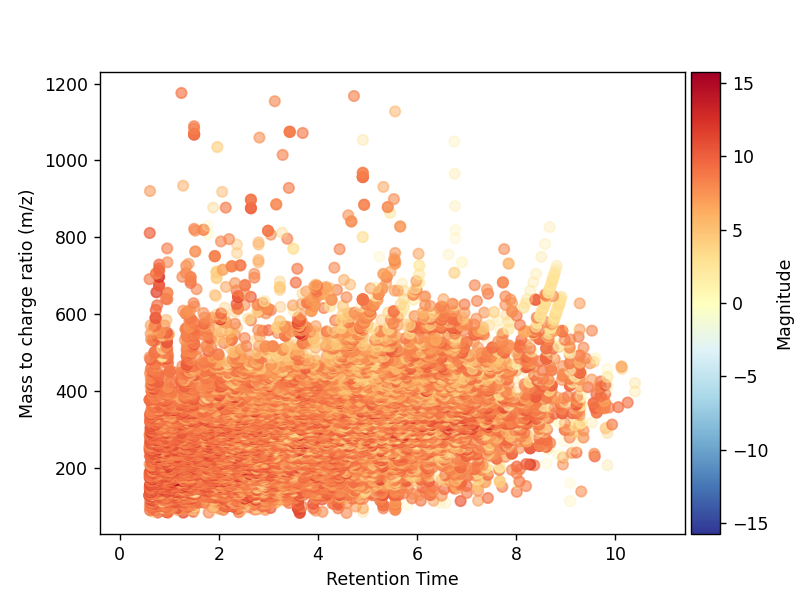

In [5]:
# Plot the dataset
# To make it more visually interesting we are loging scale the data first
log_X = np.log1p(X)

# And ploting the average data
Xm = np.mean(log_X, axis=0)

#Plot the data as scatter plot by having the xaxis: Retention Time (RT), yaxis: m/z Ratio (mz).
# and color by the average Intensity of the feature
scatterplot(Xm, xaxis=RT, yaxis=mz)

## Linear regression modeling - effect of gender


We start by assessing the effect of the gender on the intensity of each individual feature intensity using linear regression.

This model is equivalent to a 2-sample (each of the gender) *t-test* on feature intensity or a 1-way ANOVA with Gender as a single discrete covariate/factor. Other modelling alternatives are possible, for example, logistic regression.

The results from this model should be comparable with a PLS-DA model regressing the genotype (Y) on the metabolic profile variables (X). Note how the $R^{2}Y$ in the PLS-DA model refers to how well the metabolic profile is able to predict gender, while for the linear models $r^{2}$ measures how much of "metabolite" variability is explained by gender.

In next cell we will iteratively fit the same regression model, Metabolite(y) ~ Gender for each metabolic profile variable (a  feature extracted in the LC-MS dataset) value.

For each model, we obtain the calculated $r^{2}$ (variance explained), 
regression coefficients ($\beta$) for each covariate (Gender only for this first model) and the *p-value* of a two-tailed Wald test ($\beta$ significantly different from 0). 

In [6]:
# Lists to store the information
# p-value for the genotype effect
pval_genonly = list()
# regression coefficient for the genotype effect
beta_genonly = list()
# P-value for the F-test 
fpval_genonly = list()
# r2 for the regression model
r2_genonly = list()

# Fit each column with a spectral variable
for curr_variable in dataset.iloc[:, 2:]:
    # Formula for current variable
    fm = 'Q(curr_variable) ~ C(Gender)'
    mod = smf.ols(formula = fm, data=dataset)
    res = mod.fit()
    pval_genonly.append(res.pvalues[1])
    beta_genonly.append(res.params[1])
    fpval_genonly.append(res.f_pvalue)
    r2_genonly.append(res.rsquared)
    
pval_genonly = np.array(pval_genonly)
beta_genonly = np.array(beta_genonly)
r2_genonly = np.array(r2_genonly)
fpval_genonly = np.array(fpval_genonly)

## Linear modeling per variable - with adjustment for age

Adjustment for other covariates and potential confounders can be easily incorporated in linear regression.
In this case, gender and age will be modelled together. The confounding variation caused by Age will be separated from the effect of gender. 

In next cell we will iteratively fit the same regression model, Metabolite(y) ~ Gender + Age for each metabolic profile variable (feature of LC-MS) value. 

For each model, we obtain the calculated $r^{2}$ (variance explained), 
regression coefficients ($\beta$) for each covariate (Gender and Age) and the *p-value* of a two-tailed Wald test ($\beta$ significantly different from 0). 

In [7]:
# Generate lists to store the results for each varable. 


# beta_gen = the values for the regression coefficient associated with age
# pval_gen = the p-value for the t-test
# beta_age = the values for the age regression coefficients 
# pval_age = the p-values for the age regression coefficient 

# r2 = r-squared value for the entire regression model
# fpval = the p-value for the F-test of the model's r-squared

pval_gen = list()
pval_age = list()
beta_gen = list()
beta_age = list()
fpval = list()
r2 = list()

for curr_variable in dataset.iloc[:, 2:]:
    # Fit each column
    fm = 'Q(curr_variable) ~ C(Gender) + C(Age)'
    mod = smf.ols(formula = fm, data=dataset)
    res = mod.fit()
    pval_gen.append(res.pvalues[1])
    pval_age.append(res.pvalues[2])
    beta_gen.append(res.params[1])
    beta_age.append(res.params[2])
    fpval.append(res.f_pvalue)
    r2.append(res.rsquared)
    
pval_gen = np.array(pval_gen)
beta_gen = np.array(beta_gen)
pval_age = np.array(pval_age)
beta_age = np.array(beta_age)
r2 = np.array(r2)
fpval = np.array(fpval)

## Multiple testing correction

One of the problems associated with carrying out a large amount of sequential univariate tests is the potentially high number of false positives. In this instance, we have performed around 11000 tests, and at an $\alpha$ threshold of 0.05 the expected number of false positives due to chance alone is equal to $10879~\textrm{(number of tests)} \times 0.05~(\alpha) = 544$

The set of *p-values* obtained by this multiple testing strategy should be corrected to restrict the expected large number of false positives. 

In this example we use the Benjamini-Yekutieli procedure to control the false discovery 
rate (FDR) of the sequential univariate testing procedure, the proportion of "false discoveries" (false positives) in the metabolic signature uncovered (the set of positive results/rejected null hypotheses from the 11000 univariate tests).

Alternatively, Family-Wise error rate (FWER) correction methods, such as the Bonferroni correction can be used. These re-calibrate the significance threshold so that the FWER, the probability of having one or more false positives in the entirety of the analysis, is kept at a nominal $\alpha$ level (typically 0.05). FWER correction methods tend to be more stringent than FDR correction methods, but the concept of False discovery rate control is particularly suited for metabolic profiling analyses, because FDR control methods aims at controlling the general "quality" (proportion of false positives) of the uncovered signatures.

**Note**: When using FWER adjustment, we use the original *p-values* and simply adjust the $\alpha$ significance level to meet the FWER requirements. The Benjamini-Hochberg and Benjamini-Yekutieli adjustment procedures return new quantities, a set of *q-values* (one per original *p-value*). This new *q-value* should be interpreted in the context of the entire signature, and it specifies the estimated false discovery rate if all features with a *q-value* smaller or equal than the cut-off are selected as hits. For example, setting a 0.05 cut-off implies that the obtained signature has an estimated false discovery rate of 5%.

In [8]:
# Adjusting the first analysis without age
by_res_gen_only = multipletests(pval_genonly, alpha=0.05, method='fdr_by')
p_genonly_byadj = by_res_gen_only[1]

In [9]:
# Adjusting the analysis with genotype and age
by_res_gen = multipletests(pval_gen, alpha=0.05, method='fdr_by')
p_gen_byadj = by_res_gen[1]

by_res_f = multipletests(fpval, alpha=0.05, method='fdr_by')
p_byadj_f = by_res_f[1]

by_res_age = multipletests(pval_age, alpha=0.05, method='fdr_by')
p_age_byadj = by_res_age[1]

In [10]:
#Number of significant features
print("Number of features significantly associated with gender")

print("Without adjustment for age: {0}".format(sum(by_res_gen_only[0])))

print("With adjustment for age: {0}".format(sum(by_res_gen[0])))

Number of features significantly associated with gender
Without adjustment for age: 1892


In [11]:
results_dframe_genonly = pds.DataFrame(np.c_[variable_names, pval_genonly, beta_genonly, p_genonly_byadj, r2_genonly, fpval_genonly], 
                               columns=['Features', 'gender-value', 
                                        'gender_beta', 'gender_q-value', 'r2', 'f-test_pval'])
results_dframe_genonly.to_csv('./Data/UnivariateAnalysis_Gender_LCMS.csv', index=False)

In [12]:
results_dframe = pds.DataFrame(np.c_[variable_names, pval_gen, beta_gen, p_gen_byadj, pval_age, beta_age, p_age_byadj,
                                     r2, fpval], 
                               columns=['Features', 'gender_p-value', 
                                        'gender_beta', 'gender_q-value', 'age_p-value', 'age_beta', 
                                        'age_q-value', 'r2', 'f-test_pval'])
results_dframe.to_csv('./Data/UnivariateAnalysis_Gender_Age_LCMS.csv', index=False)


A histogram of the *p-value* distribution shows a mostly uniform distribution, with a heavy tail at the lower end (towards 0).

<IPython.core.display.Javascript object>


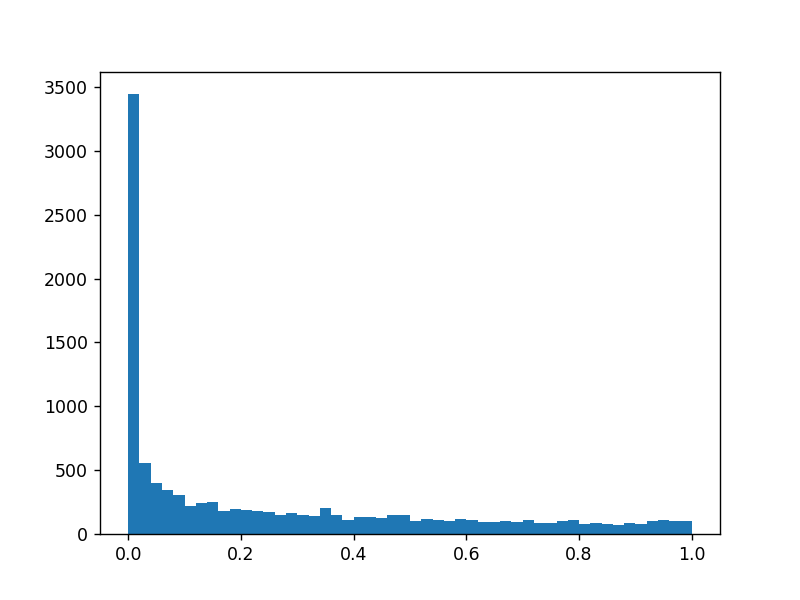

In [13]:
plt.figure()
plt.hist(pval_gen, 50)
plt.show()

Saving the results for comparison with the PLS-DA modelling results. The steps for this comparison are in the **Multivariate analysis with PLS-DA notebook.**

## Model resampling - bootstrapping

In the multivariate modeling steps, cross-validation was used during model validation to obtain uncertainty estimates for the quality of the PLS model and its parameters.

In univariate analysis using linear regression or any other statistical test, jacknifing, bootstrapping and other cross-validation and resampling techniques can also be used to obtain more reliable confidence intervals for model parameters and statistics.

The confidence of the results can be further assessed by observing the bootstrap distribution for *p-values* or test statistics, such as the $\beta$ coefficients.

### Optional: model bootstrapping - Parallel implementation
Non-parametric bootstrapping of cases. Run time is approximately 120 minutes on a PC with 8 cores.

In [14]:
# Define function that can be called by each worker:
def bootstrap_model(variable, n_boot, dataset):    
    boot_stats = np.zeros((n_boot, 6))
    
    for boot_iter in range(n_boot):
        boot_sample = np.random.choice(dataset.shape[0], dataset.shape[0], replace=True)
        fm = 'Q(dataset.columns[variable]) ~ C(Gender) + C(Age)'
        mod = smf.ols(formula = fm, data=dataset.iloc[boot_sample, :])
        res = mod.fit()
        boot_stats[boot_iter, 0] = res.pvalues[1]
        boot_stats[boot_iter, 1] = res.pvalues[2]
        boot_stats[boot_iter, 2] = res.params[1]
        boot_stats[boot_iter, 3] = res.params[2]
        boot_stats[boot_iter, 4] = res.f_pvalue
        boot_stats[boot_iter, 5] = res.rsquared
    return boot_stats

In [ ]:
import joblib
results = joblib.Parallel(n_jobs=8, verbose=5, pre_dispatch='2*n_jobs')(joblib.delayed(bootstrap_model)(i, 50, dataset) for i in range(2, dataset.shape[1])) 

In [15]:
# Save and load pre-computed results.
# np.save('bootstrap_results_univariate_LCMS.npy', results)
results = np.load('bootstrap_results_univariate_LCMS.npy')

In [16]:
# mean and standard deviation for regression coefficients and wald test p-values
# Gender
mean_beta_gen = np.array([x[:, 2].mean() for x in results])
std_beta_gen = np.array([x[:, 2].std() for x in results])
mean_p_gen = np.array([x[:, 0].mean() for x in results])
std_p_gen = np.array([x[:, 0].std() for x in results])
# Age
mean_beta_age = np.array([x[:, 3].mean() for x in results])
std_beta_age = np.array([x[:, 3].std() for x in results])
mean_p_age = np.array([x[:, 1].mean() for x in results])
std_p_age = np.array([x[:, 1].std() for x in results])

# Visualization of results
We can now assess the regression coefficients obtained for each factor and the *p-value* corresponding to the two-tailed Wald t-test of $\beta \neq 0$

<IPython.core.display.Javascript object>


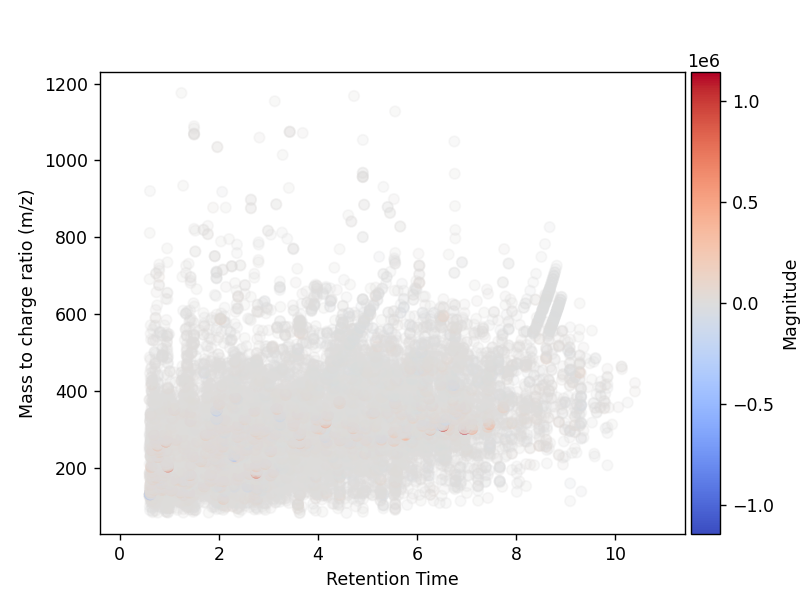

<IPython.core.display.Javascript object>


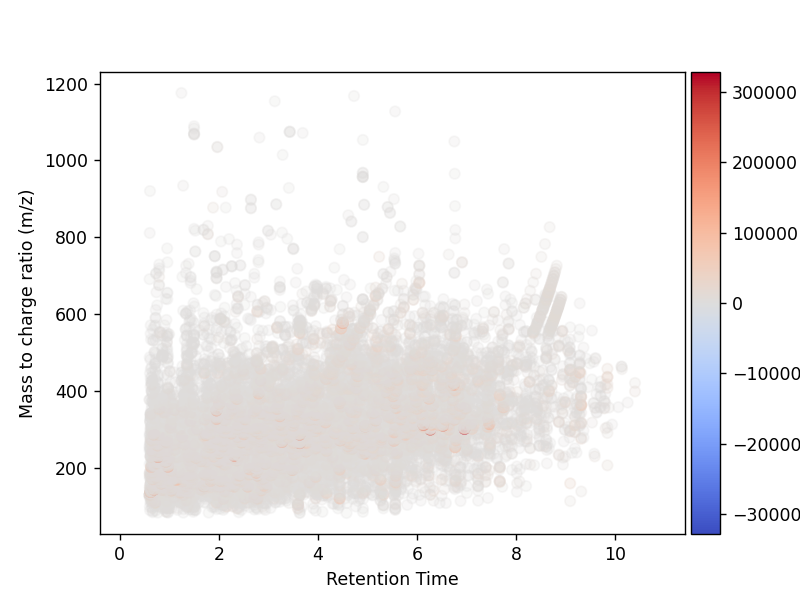

In [17]:
# Visualization of regression coefficients with Bootstrap confidence intervals
cmap = mpl.colormaps['coolwarm']
scatterplot(mean_beta_gen, xaxis=RT, yaxis=mz, colormap=cmap)

scatterplot(std_beta_gen, xaxis=RT, yaxis=mz, colormap=cmap)
# Run the following line instead if bootstrapping wasn't done
# scatterplot(beta_gen, xaxis=RT, yaxis=mz, colormap=cmap)

A Manhattan plot combines the regression coefficient estimate with the magnitude of the *p-value*. The first (estimated $\beta$) is encoded on the colorscale, while the base 10 logarithm of the *p-value* multiplied by the sign of the regression coefficient are plotted in the y axis.

The next figures contain a Manhattan plot style visualization for the effect of the Age covariate...

<IPython.core.display.Javascript object>


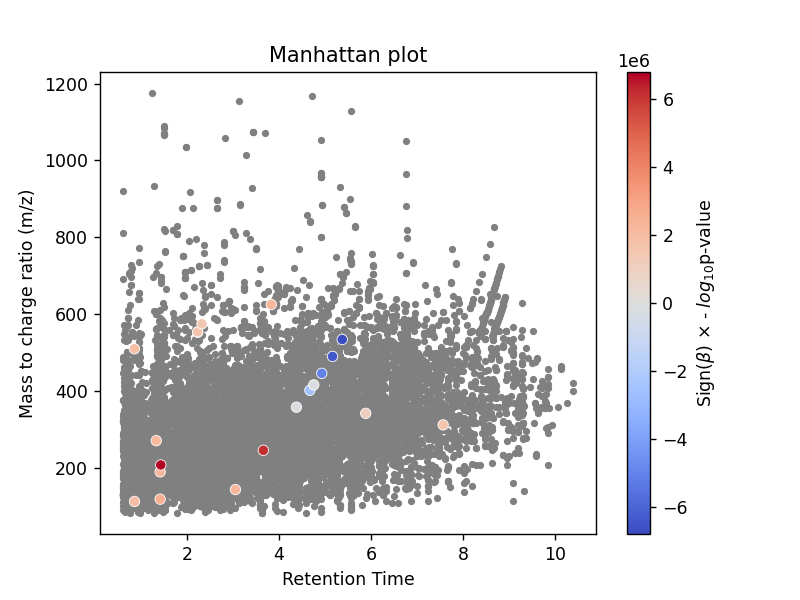

In [27]:
manhattan_plot(p_age_byadj, beta_age, instrument='lcms', xaxis=RT, yaxis=mz)

**Note:** This is a Manhattan plot adapted for the 2D LC-MS data set. In this adapted graph, the non-significant features are plotted in grey, and the rest of the features are plotted with their color according to their *beta* value


... and for the effect of gender. 

<IPython.core.display.Javascript object>


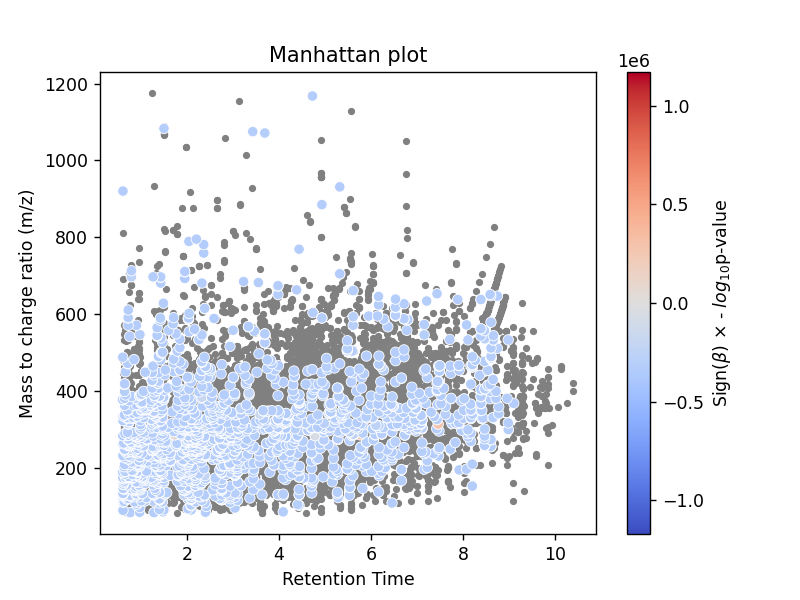

In [29]:
manhattan_plot(p_gen_byadj, beta_gen, instrument='lcms', xaxis=RT, yaxis=mz)

The **interactive_manhattan** function generates an interactive version of Manhattan Plot, here exemplified for the age covariate.

In [90]:
iplot(interactive_manhattan(p_age_byadj, beta_age, instrument='lcms', xaxis=RT, yaxis=mz))